/tmp/ipykernel_28058/2176050175.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[ma_columns] = data[ma_columns].fillna(method='bfill')


Epoch 1/15


2025-01-08 09:29:50.658540: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.5340 - mean_absolute_percentage_error: 95.6192 - val_loss: 0.4243 - val_mean_absolute_percentage_error: 81.9826
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.4010 - mean_absolute_percentage_error: 73.7972 - val_loss: 0.2337 - val_mean_absolute_percentage_error: 52.9906
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1995 - mean_absolute_percentage_error: 47.8501 - val_loss: 0.0844 - val_mean_absolute_percentage_error: 59.9293
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1178 - mean_absolute_percentage_error: 55.4356 - val_loss: 0.0765 - val_mean_absolute_percentage_error: 55.2255
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0971 - mean_absolute_percentage_error: 39.5402 - val_loss: 0.0743 - val_mean_absolute_percentage_error: 52.7302
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0715 - mean_absolute_percentage_error: 39.0387 - val_loss: 0.0765 - val_mean_absolute

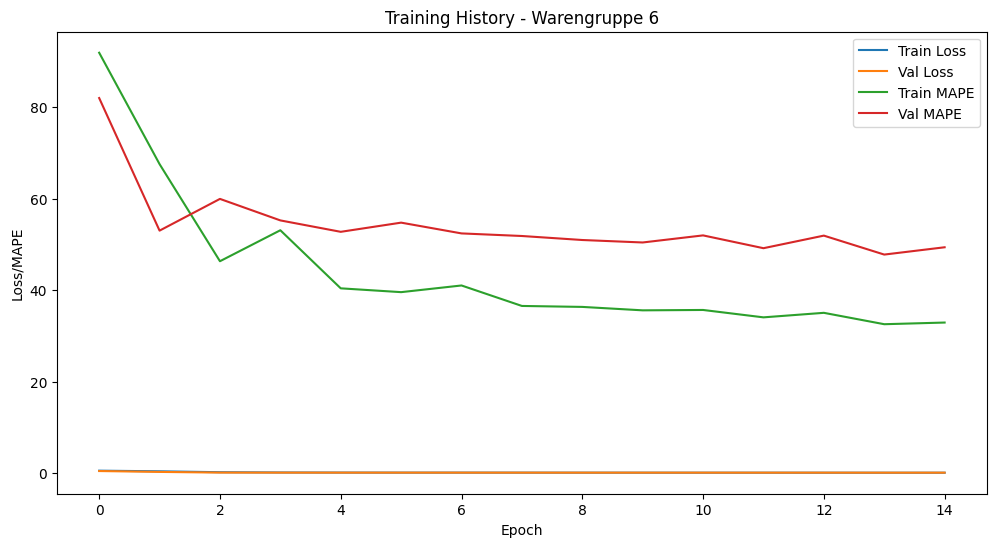

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step

MAPE for Warengruppe 6: 47.76%


KeyError: 'Umsatz'

In [2]:
'''
This version:

- Creates separate model for Warengruppe 6
- Adds moving averages features
- Normalizes Warengruppe 6 sales
- Uses deeper network with smaller batch size
- Includes exponential moving averages and volatility metrics

'''

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

def add_ma_features(data):
    data = data.sort_values('Datum')
    data['MA7'] = data['Umsatz'].rolling(window=7, min_periods=1).mean()
    data['MA30'] = data['Umsatz'].rolling(window=30, min_periods=1).mean()
    data['EMA7'] = data['Umsatz'].ewm(span=7, adjust=False).mean()
    data['Volatility7'] = data['Umsatz'].rolling(window=7, min_periods=1).std()
    data['MA_Ratio'] = data['MA7'] / data['MA30']
    
    ma_columns = ['MA7', 'MA30', 'EMA7', 'Volatility7', 'MA_Ratio']
    data[ma_columns] = data[ma_columns].fillna(method='bfill')
    return data

# Load data
kiwo_url = '../../Data/kiwo.csv'
umsatz_url = '../../Data/train.csv'
wetter_url = '../../Data/wetter.csv'
test_url = '../../Data/test.csv'

df_kiwo = pd.read_csv(kiwo_url)
df_umsatz = pd.read_csv(umsatz_url)
df_wetter = pd.read_csv(wetter_url)
df_test = pd.read_csv(test_url)

# Merge data
df_train = pd.merge(df_umsatz, df_wetter, on='Datum', how='left')
df_train = pd.merge(df_train, df_kiwo, on='Datum', how='left')
df_test = pd.merge(df_test, df_wetter, on='Datum', how='left')
df_test = pd.merge(df_test, df_kiwo, on='Datum', how='left')

def prepare_data(data):
    data['Datum'] = pd.to_datetime(data['Datum'])
    data['DayOfWeek'] = data['Datum'].dt.dayofweek
    data['Month'] = data['Datum'].dt.month
    data['IsWeekend'] = (data['DayOfWeek'] >= 5).astype(float)
    data['KielerWoche'] = data['KielerWoche'].fillna(0).astype(float)
    
    # Add seasonal features
    peak_months = [7, 8, 12]
    data['IsPeakSeason'] = data['Month'].isin(peak_months).astype(float)
    data['MonthSineCurve'] = np.sin(2 * np.pi * data['Month']/12)
    data['MonthCosineCurve'] = np.cos(2 * np.pi * data['Month']/12)
    
    numerical_cols = ['Temperatur', 'Windgeschwindigkeit', 'Bewoelkung', 'Wettercode', 
                     'IsWeekend', 'IsPeakSeason', 'MonthSineCurve', 'MonthCosineCurve',
                     'MA7', 'MA30', 'EMA7', 'Volatility7', 'MA_Ratio']
    
    knn_imputer = KNNImputer(n_neighbors=5)
    data[numerical_cols] = knn_imputer.fit_transform(data[numerical_cols])
    
    warengruppe_dummies = pd.get_dummies(data['Warengruppe'], prefix='Warengruppe')
    data['Warengruppe6_Peak'] = (data['Warengruppe'] == 6) * data['IsPeakSeason']
    data['Warengruppe6_Temp'] = (data['Warengruppe'] == 6) * data['Temperatur']
    
    feature_df = pd.concat([
        data[numerical_cols],
        warengruppe_dummies,
        pd.get_dummies(data['DayOfWeek'], prefix='Day'),
        pd.get_dummies(data['Month'], prefix='Month')
    ], axis=1)
    
    return feature_df

# Prepare datasets
df_train_sorted = df_train.sort_values(by='Datum')
df_train_sorted = add_ma_features(df_train_sorted)

# Separate Warengruppe 6
df_train_6 = df_train_sorted[df_train_sorted['Warengruppe'] == 6].copy()
df_train_other = df_train_sorted[df_train_sorted['Warengruppe'] != 6].copy()

# Normalize within Warengruppe 6
df_train_6['Umsatz_norm'] = df_train_6['Umsatz'] / df_train_6['Umsatz'].mean()

# Prepare features
X_train_6 = prepare_data(df_train_6)
y_train_6 = df_train_6['Umsatz_norm']

X_train_other = prepare_data(df_train_other)
y_train_other = df_train_other['Umsatz']

# Split data for Warengruppe 6
split_idx_6 = int(len(X_train_6) * 0.8)
scaler = StandardScaler()
X_train_seq_6 = scaler.fit_transform(X_train_6[:split_idx_6])
X_val_seq_6 = scaler.transform(X_train_6[split_idx_6:])
y_train_seq_6 = y_train_6[:split_idx_6]
y_val_seq_6 = y_train_6[split_idx_6:]

# Reshape for LSTM
X_train_seq_6 = X_train_seq_6.reshape(-1, 1, X_train_seq_6.shape[1])
X_val_seq_6 = X_val_seq_6.reshape(-1, 1, X_val_seq_6.shape[1])


# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_wg6.keras', monitor='val_loss', save_best_only=True)

# Build specialized model for Warengruppe 6
model_6 = tf.keras.Sequential([
    LSTM(256, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

model_6.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
                loss='huber',
                metrics=['mean_absolute_percentage_error'])

# Train model for Warengruppe 6
history_6 = model_6.fit(
    X_train_seq_6, y_train_seq_6,
    epochs=15,
    batch_size=16,
    validation_data=(X_val_seq_6, y_val_seq_6),
    callbacks=[early_stopping, model_checkpoint]
)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history_6.history['loss'], label='Train Loss')
plt.plot(history_6.history['val_loss'], label='Val Loss')
plt.plot(history_6.history['mean_absolute_percentage_error'], label='Train MAPE')
plt.plot(history_6.history['val_mean_absolute_percentage_error'], label='Val MAPE')
plt.title('Training History - Warengruppe 6')
plt.xlabel('Epoch')
plt.ylabel('Loss/MAPE')
plt.legend()
plt.show()

# Evaluate model
model_6.load_weights('best_model_wg6.keras')
val_predictions_6 = model_6.predict(X_val_seq_6).flatten()

# Calculate MAPE for Warengruppe 6
mape_6 = tf.keras.metrics.MeanAbsolutePercentageError()(
    y_val_seq_6 * df_train_6['Umsatz'].mean(),  # Denormalize
    val_predictions_6 * df_train_6['Umsatz'].mean()
).numpy()

print(f"\nMAPE for Warengruppe 6: {mape_6:.2f}%")

# Prepare test data similarly
df_test_sorted = df_test.sort_values(by='Datum')
df_test_6 = df_test_sorted[df_test_sorted['Warengruppe'] == 6].copy()
df_test_6 = add_ma_features(df_test_6)
X_test_6 = prepare_data(df_test_6)
X_test_6 = StandardScaler().fit_transform(X_test_6)
X_test_6 = X_test_6.reshape(-1, 1, X_test_6.shape[1])

# Make predictions
test_predictions_6 = model_6.predict(X_test_6).flatten() * df_train_6['Umsatz'].mean()
df_test.loc[df_test['Warengruppe'] == 6, 'Predicted_Umsatz'] = test_predictions_6

# Save predictions
df_test.to_csv('predicted_test.csv', index=False)